In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
sahilislam007/health-and-lifestyle-dataset                   Health And Lifestyle Dataset                            123230  2025-06-25 09:52:01.580000           1239         29  1.0              
khwaishsaxena/vehicle-price-prediction-dataset               Vehicle Price Prediction Dataset                        307492  2025-06-23 05:12:07.013000            909         23  1.0              
adilshamim8/social-media-addiction-vs-relationships          Students' Social Media Addiction                          7851  2025-05-10 14:38:02.713000          25051        364  1.0              
urvishahir/elec

In [ ]:
!kaggle competitions download -c 'nthuddd2'

403 Client Error: Forbidden for url: https://www.kaggle.com/api/v1/competitions/data/download-all/nthuddd2


In [ ]:
import kagglehub
path = kagglehub.dataset_download("banudeep/nthuddd2")

In [ ]:
!ls /kaggle/input/nthuddd2//train_data/notdrowsy | head -n 10

001_glasses_nonsleepyCombination_0_notdrowsy.jpg
001_glasses_nonsleepyCombination_1000_notdrowsy.jpg
001_glasses_nonsleepyCombination_1001_notdrowsy.jpg
001_glasses_nonsleepyCombination_1002_notdrowsy.jpg
001_glasses_nonsleepyCombination_1003_notdrowsy.jpg
001_glasses_nonsleepyCombination_1004_notdrowsy.jpg
001_glasses_nonsleepyCombination_1005_notdrowsy.jpg
001_glasses_nonsleepyCombination_1006_notdrowsy.jpg
001_glasses_nonsleepyCombination_1007_notdrowsy.jpg
001_glasses_nonsleepyCombination_1008_notdrowsy.jpg
ls: write error: Broken pipe


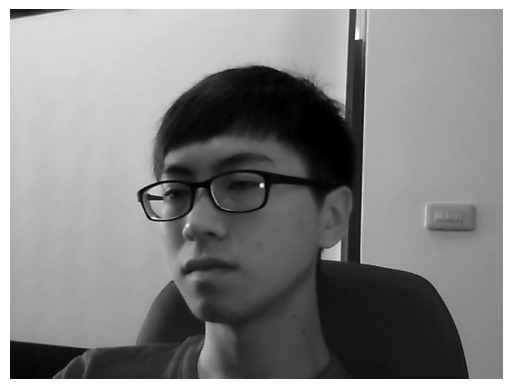

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load image
image = Image.open("/kaggle/input/nthuddd2/train_data/drowsy/001_glasses_sleepyCombination_1000_drowsy.jpg")

# Display image inline
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

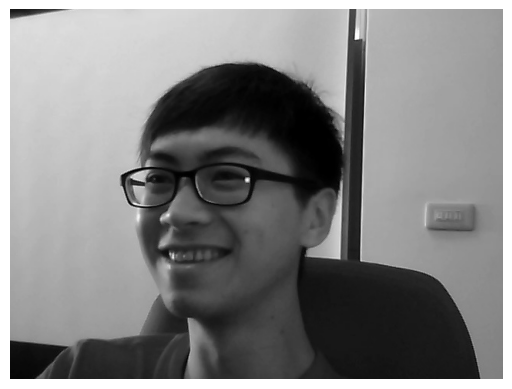

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Load image
image = Image.open("/kaggle/input/nthuddd2/train_data/notdrowsy/001_glasses_nonsleepyCombination_1000_notdrowsy.jpg")

# Display image inline
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import random_split
from tqdm import tqdm


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder("/kaggle/input/nthuddd2/train_data", transform=transform)

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"{train_size} :  {val_size} : {test_size}")

46564 :  9978 : 9979


In [ ]:
class DrowsyCNN(nn.Module):
    def __init__(self):
        super(DrowsyCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.fc(self.conv(x))

In [ ]:
device = "cuda"
model = DrowsyCNN()
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)


epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]")
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total += labels.size(0)

        train_bar.set_postfix(loss=loss.item(), accuracy=100 * train_correct / total)

    torch.save(model.state_dict(), f"drowsy_model_epoch_{epoch+1}.pth")
    model.eval()
    val_loss, val_correct = 0, 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

            val_bar.set_postfix(loss=loss.item(), accuracy=100 * val_correct / len(val_loader.dataset))

    print(f"Epoch {epoch+1}/{epochs} Summary --> "
          f"Train Acc: {100 * train_correct / total:.2f}%, "
          f"Val Acc: {100 * val_correct / len(val_loader.dataset):.2f}%")


model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f"🧪 Final Test Accuracy: {test_acc:.2f}%")


Let's use 2 GPUs!


Epoch 1/5 [Validation]: 100%|██████████| 312/312 [01:21<00:00,  3.83it/s, accuracy=98.2, loss=0.142]


Epoch 1/5 Summary --> Train Acc: 93.78%, Val Acc: 98.17%


Epoch 2/5 [Validation]: 100%|██████████| 312/312 [01:19<00:00,  3.92it/s, accuracy=98.7, loss=0.122]


Epoch 2/5 Summary --> Train Acc: 98.29%, Val Acc: 98.67%


Epoch 3/5 [Validation]: 100%|██████████| 312/312 [01:18<00:00,  3.99it/s, accuracy=98.3, loss=0.126]


Epoch 3/5 Summary --> Train Acc: 98.93%, Val Acc: 98.31%


Epoch 4/5 [Validation]: 100%|██████████| 312/312 [01:16<00:00,  4.08it/s, accuracy=99.1, loss=0.0509]


Epoch 4/5 Summary --> Train Acc: 99.10%, Val Acc: 99.15%


Epoch 5/5 [Validation]: 100%|██████████| 312/312 [01:19<00:00,  3.93it/s, accuracy=99.2, loss=0.00564]


Epoch 5/5 Summary --> Train Acc: 99.28%, Val Acc: 99.21%


Testing: 100%|██████████| 312/312 [01:17<00:00,  4.05it/s]

🧪 Final Test Accuracy: 99.21%


In [ ]:
!ls

drowsy_model_epoch_1.pth  drowsy_model_epoch_3.pth  drowsy_model_epoch_5.pth
drowsy_model_epoch_2.pth  drowsy_model_epoch_4.pth  kaggle.json
